In [1]:
import os
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn import metrics
from tqdm import tqdm
import requests

In [2]:
data = np.load('feature_dataset_latest.npy', allow_pickle='TRUE').item()

In [3]:
model = RandomForestClassifier(max_depth=18, n_estimators=831, random_state=42)
score_types = ('accuracy', 'roc_auc', 'f1')

In [4]:
result = cross_validate(model, data['features'], data['labels'],
                        cv=KFold(shuffle=True, random_state=42),
                        scoring=score_types,
                        return_estimator=True,
                        return_train_score=True,
                       )

In [5]:
for score in score_types:
    mean = np.mean(result[f'test_{score}'])
    std = np.std(result[f'test_{score}'])
    print(f'{score} = {mean:.3f} +- {std:.3f}')

accuracy = 0.863 +- 0.016
roc_auc = 0.940 +- 0.014
f1 = 0.862 +- 0.019


In [14]:
clf = result['estimator'][0]

## Take random field and predict labels for each object

In [22]:
field = '280'
field_oids = np.memmap(f'akb_features/oid_{field}.dat', mode='r', dtype=np.uint64)
            
with open(f'akb_features/feature_{field}.name') as f:
    names = f.read().split()
dtype = [(name, np.float32) for name in names]
field_feature = np.memmap(f'akb_features/feature_{field}.dat', mode='r', dtype=dtype, shape=field_oids.shape)

In [15]:
field_predict = clf.predict_proba(field_feature.tolist())

In [34]:
field_oids = np.array(field_oids.tolist())

arg_sort = np.argsort(field_predict[:, 1])

normal_proba = field_predict[arg_sort[:10]]
artefact_proba = field_predict[arg_sort[-10:]][::-1]

most_normal = field_oids[arg_sort[:10]]
most_artefact = field_oids[arg_sort[-10:]][::-1]

print('Most normal objects:')
for i in range(10):
    print(f'{most_normal[i]}    {normal_proba[i][1]:.3f}')


print('\n ----------------------------- \n')
print('Most artefact objects:')
for i in range(10):
    print(f'{most_artefact[i]}    {artefact_proba[i][1]:.3f}')

Most normal objects:
280209300013386    0.091
280202300029399    0.096
280209300020952    0.096
280203200060868    0.096
280209300018866    0.097
280201100132081    0.099
280214100018900    0.100
280209300014954    0.100
280202300065490    0.102
280206200021577    0.103

 ----------------------------- 

Most artefact objects:
280210100183800    0.998
280207200190520    0.996
280209400029500    0.995
280209300044856    0.995
280205400100693    0.995
280206100145697    0.995
280205200123445    0.995
280208300089260    0.994
280206400074517    0.994
280214300085624    0.994


## Closest to 0.5 probability objects

In [39]:
def find_nearest(array, value, num=10):
    array = np.asarray(array)
    idx = np.argsort(np.abs(array - value))[:num]
    return array[idx], idx

In [40]:
_, idx = find_nearest(field_predict[:,1], 0.5)

In [42]:
for oid in field_oids[idx]:
    print(f'https://ztf.snad.space/view/{oid}')

https://ztf.snad.space/view/280204300128140
https://ztf.snad.space/view/280208200149092
https://ztf.snad.space/view/280213200160123
https://ztf.snad.space/view/280205300076857
https://ztf.snad.space/view/280205300157086
https://ztf.snad.space/view/280202400052403
https://ztf.snad.space/view/280207100004592
https://ztf.snad.space/view/280202400138127
https://ztf.snad.space/view/280203400067078
https://ztf.snad.space/view/280213200180974


In [44]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

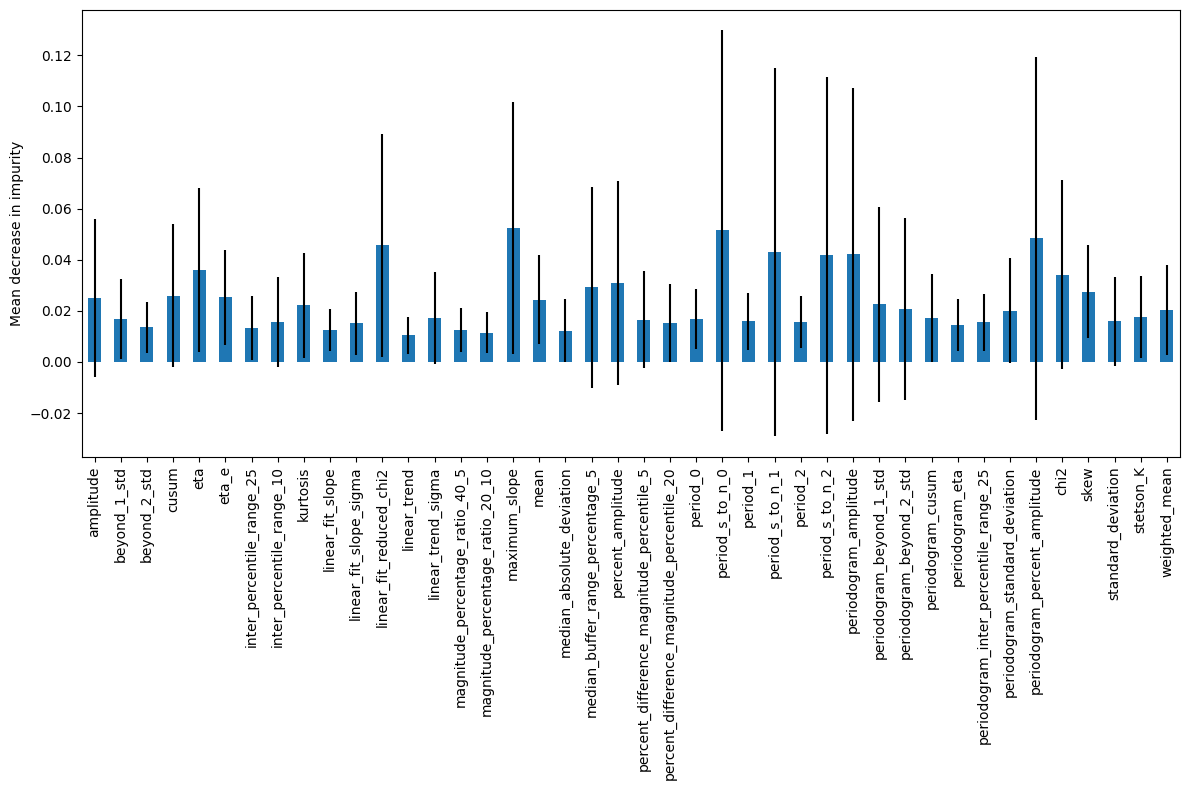

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=names)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [53]:
field_predict[:,1].shape

(8912487,)